In [ ]:
!pip install langchain langgraph langchain-community langchain-core langchain-openai chromadb langchain_groq langchain_huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.1 MB/s eta 0:00

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages , AnyMessage
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI , OpenAIEmbeddings

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm_model=ChatGroq(model_name="Gemma2-9b-It")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-collection",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

# Document Grader

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [ ]:
structured_llm_grader = llm_model.with_structured_output(GradeDocuments)

In [ ]:
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..
If the document has words or meanings related to the question, mark it as relevant.
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""

grade_prompt = ChatPromptTemplate([
    ('system', system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
])

In [ ]:
grade_prompt

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  \nIf the document has words or meanings related to the question, mark it as relevant.  \nGive a simple 'yes' or 'no' answer to show if the document is relevant or not."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])

In [ ]:
retrieval_grader = grade_prompt | structured_llm_grader


In [ ]:
docs = retriever.get_relevant_documents("What is ai agent")

/tmp/ipython-input-335985794.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("What is ai agent")


In [ ]:
retrieval_grader.invoke({'document':docs,'question':"What is ai agent"}).binary_score

'yes'

# Data generation

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [ ]:
rag_chain = prompt | llm_model

In [ ]:
generation = rag_chain.invoke({'context':docs,"question": "What is ai agent"})

# Hallucination Grader

In [ ]:
class GradeHallucination(BaseModel) :
  """ Binary score for hallucination present in generation answer. """
  binary_score : str = Field(description = "Answer is ground in the facts, 'yes' or 'no'")

In [ ]:
structured_llm_grader = llm_model.with_structured_output(GradeHallucination)

In [ ]:
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [ ]:
hallucination_grader = hallucination_prompt | structured_llm_grader

In [ ]:
hallucination_grader.invoke({'documents':docs,'generation':"What is ai agent"})

GradeHallucination(binary_score='yes')

# Answer Grader

In [ ]:
class GraderAnswer (BaseModel) :
  """ Binary score to assess answer address question"""
  binary_score : str = Field(description = "Answer is ground in the facts, 'yes' or 'no' ")

In [ ]:
structured_llm_grader = llm_model.with_structured_output(GraderAnswer)

In [ ]:
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": 'what is ai agent', "generation": generation}))

binary_score='yes'


# Question Rewriter

In [ ]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.
You are given both a question and a document.
- First, check if the question is relevant to the document by identifying a connection or relevance between them.
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm_model | StrOutputParser()

In [ ]:
question = "Who is cristiano Ronaldo ?"

In [ ]:
question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant \n'

# Making the state class

In [ ]:
from typing import List
class AgentState (TypedDict) :
  question : str
  generation : str
  documents  : List[str]
  filter_documents : List[str]
  unfilter_documents : List[str]

In [ ]:
def retrieve (state : AgentState) :
  print('------ Retrieve ----------')
  question = state['question']
  documents = retriever.get_relevant_documents(question)
  return {'documents':documents , 'question':question}


In [ ]:
def grade_documents (state: AgentState) :
  print('------ Grade Documents relevance to the question----------')
  documents = state['documents']
  question = state['question']
  filter_docs = []
  unfilter_docs =[]

  for doc in documents :
    score = retrieval_grader.invoke({'question': question,'document':doc})
    grade = score.binary_score

    if grade == 'yes' :
      print("----GRADE: DOCUMENT RELEVANT----")
      filter_docs.append(doc)
    else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfilter_docs.append(doc)
  if len(unfilter_docs)>1:
        return {"unfilter_documents": unfilter_docs,"filter_documents":[], "question": question}
  else:
        return {"filter_documents": filter_docs,"unfilter_documents":[],"question": question}

In [ ]:
def decide_to_generate (state : AgentState) :
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]


    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [ ]:

def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]

    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [ ]:
def transform_query (state: AgentState) :
  question = state['question']
  documents = state['documents']

  response = question_rewriter.invoke({"question" : question , 'documents' : documents})

  print(f"------ RESPONSE ------- {response}")

  if response == "question not relevant":
    print("----QUESTION IS NOT AT ALL RELEVANT----")
    return {"documents":documents,"question":response,"generation":"question was not at all relevant"}

  else :
    return {"documents":documents , "question": response}

In [ ]:

def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]

    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [ ]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents":documents,"generation":generation})

    grade = score.binary_score

    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        print("---GRADE GENERATION vs QUESTION ---")

        score = answer_grader.invoke({"question":question,"generation":generation})

        grade = score.binary_score

        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"

In [ ]:
workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents)
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [ ]:

workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [ ]:
app=workflow.compile()

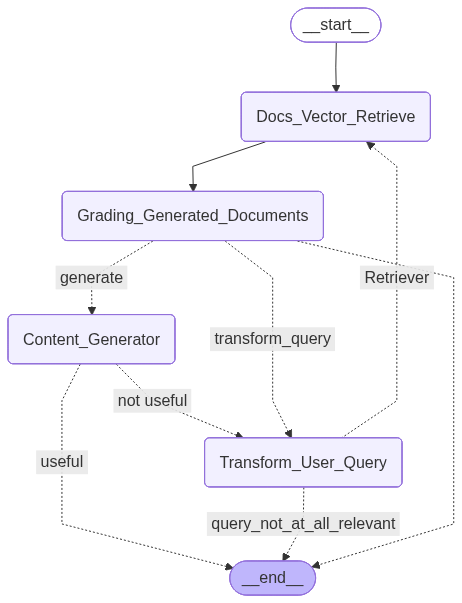

In [ ]:

from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [ ]:
app.invoke(inputs)["generation"]

------ Retrieve ----------
------ Grade Documents relevance to the question----------
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='LLM-powered agents use short-term memory for in-context learning, which is like remembering things from the current conversation. \n\nLong-term memory, often stored externally, allows agents to retain vast amounts of information over extended periods.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 2139, 'total_tokens': 2192, 'completion_time': 0.096363636, 'prompt_time': 0.044142698, 'queue_time': 0.027422801, 'total_time': 0.140506334}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--f6fa25a3-d8ce-4f45-a0b5-b2e3cc94d221-0', usage_metadata={'input_tokens': 2139, 'output_tokens': 53, 'total_tokens': 2192})

In [ ]:
inputs = {"question": "what is role of c language and php while creating ai agentic pattern?"}

In [ ]:

app.invoke(inputs)["generation"]

------ Retrieve ----------
------ Grade Documents relevance to the question----------
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
------ RESPONSE ------- What role do LLMs play in the planning and memory components of an AI agent system? 




------ Retrieve ----------
------ Grade Documents relevance to the question----------
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='LLMs in an AI agent system handle planning by breaking down large tasks into smaller subgoals and reflecting on past actions to refine future steps.  They use short-term memory for in-context learning and long-term memory to store and recall information over extended periods. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 2047, 'total_tokens': 2104, 'completion_time': 0.103636364, 'prompt_time': 0.038392809, 'queue_time': 0.103075765, 'total_time': 0.142029173}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--737daf47-958f-42a4-9f79-c129ec63a527-0', usage_metadata={'input_tokens': 2047, 'output_tokens': 57, 'total_tokens': 2104})